## Art Recommendation using CLIP, FAISS and Content-Base Filtering

## Context

The goal of this project is to create the recommandation algorithm for a web application that allows users to find art they truly like !
The app will work in 2 steps : 
 1) The user swipes through a dozen of art pieces 
 2) The application recommands art pieces tailored to their taste

### Dataset :
The dataset used for this project is a subset of the wikiart dataset (https://www.kaggle.com/datasets/steubk/wikiart). This subset contains 15133 pieces and the number of pieces per genre shown below : 

| Genre | # of Artworks |
|----------|----------|
| Baroque  | 4220  |
| Art Nouveau Modern  | 4125  |
| Abstract Expressionism  | 2592 |
| Cubism  | 2139  |
| Color Field Painting  | 1576  |
| Contemporary Realism  |  481 |

### Technical approach
The first step will be to embed all the artworks into a vector space using CLIP Model and the second will be to compute similarity search on those vectors. The objective is to build a function that returns the top 10 most similar artworks when given an artwork as entry.



## Part 0 : Imports

In [20]:
import os
import torch
from PIL import Image, ImageOps
from transformers import CLIPProcessor, CLIPModel
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import faiss
import numpy as np
import ast

## Part 1 : Artwork Embedding

In order to compute similarity search on artworks we need to transform them into comparable objects. The machine cannot tell if 2 artworks are similar by just looking at their pixel matrixes. That's why we are going to use the CLIP model to embed the artworks into vectors (https://arxiv.org/abs/2103.00020). CLIP is a pre-trained Image and Text Encoder that allows us to transform our image matrixes into 512 length vectors.

In [14]:
dataset = pd.read_csv("wikiart_subset.csv")

In [15]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

In [ ]:
def get_image_embeddings(filename):
    if not os.path.exists(filename):
        return 0
    
    image = Image.open(filename).convert("RGB")
    image = ImageOps.pad(image, (224, 224), color=(255, 255, 255))
    
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    vector  = image_features.squeeze().tolist()

    return vector 

In [17]:
dataset['vector'] = dataset['filename'].progress_apply(get_image_embeddings)

100%|██████████| 16564/16564 [11:24<00:00, 24.20it/s] 


## Part 2 : Similarity search

In [18]:
clean_dataset = pd.read_csv("dataset_with_vectors.csv")

### a/ soft clustering & similarity search using PCA + GMM 

In [57]:
# Apply PCA to reduce dimensions
n_components = 200
clean_dataset['vector'] = clean_dataset['vector'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
vectors_array = np.array(clean_dataset['vector'].tolist()).astype('float32')
pca = PCA(n_components=n_components)
vectors_pca = pca.fit_transform(vectors_array)

print(f"Original dimension: {vectors_array.shape[1]}")
print(f"Reduced dimension: {vectors_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Original dimension: 512
Reduced dimension: 200
Explained variance ratio: 0.9105


/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/pierregourdou/Docume

We keep 200 dimensions that explains 91% of the variance. The more dimensions we keep, the more variance we keep but the more computational efficiency we loose.

In [61]:
# Apply Gaussian Mixture Model clustering
n_clusters = 6 # because we have 6 genres
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
cluster_labels = gmm.fit_predict(vectors_pca)

clean_dataset['cluster'] = cluster_labels

print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution:")
print(clean_dataset['cluster'].value_counts().sort_index())

/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pierregourdou/Documents/art_r

Number of clusters: 6
Cluster distribution:
cluster
0    3191
1    1681
2    1914
3    2241
4    2636
5    3471
Name: count, dtype: int64


/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/mixture/_gaussian_mixture.py:937: RuntimeWarning: divide by zero encountered in matmul
  self.precisions_[k, :, :] = prec_chol @ prec_chol.T
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/mixture/_gaussian_mixture.py:937: RuntimeWarning: overflow encountered in matmul
  self.precisions_[k, :, :] = prec_chol @ prec_chol.T
/Users/pierregourdou/Documents/art_recommandation/venv/lib/python3.13/site-packages/sklearn/mixture/_gaussian_mixture.py:937: RuntimeWarning: invalid value encountered in matmul
  self.precisions_[k, :, :] = prec_chol @ prec_chol.T


In [62]:
def get_similar_artworks_gmm(phash, k=10):
    """
    Find k most similar artworks using GMM clustering and PCA-reduced vectors.
    
    Parameters:
    - phash: The phash of the artwork to find similar pieces for
    - k: Number of similar artworks to return (default: 10)
    
    Returns:
    - DataFrame with the k most similar artworks
    """
    artwork_row = clean_dataset[clean_dataset['phash'] == phash]
    
    if artwork_row.empty:
        print(f"No artwork found with phash: {phash}")
        return None
    
    # Get the cluster of the query artwork
    query_cluster = artwork_row['cluster'].iloc[0]
    query_idx = artwork_row.index[0]
    
    # Get artworks from the same cluster
    same_cluster = clean_dataset[clean_dataset['cluster'] == query_cluster]
    
    # Get the PCA-reduced vector of the query artwork
    query_vector_pca = vectors_pca[clean_dataset.index.get_loc(query_idx)].reshape(1, -1)
    
    # Calculate distances to all artworks in the same cluster
    cluster_indices = [clean_dataset.index.get_loc(idx) for idx in same_cluster.index]
    cluster_vectors_pca = vectors_pca[cluster_indices]
    
    # Compute Euclidean distances
    distances = np.linalg.norm(cluster_vectors_pca - query_vector_pca, axis=1)
    
    # Get indices of k+1 nearest neighbors (excluding the query itself)
    nearest_indices = np.argsort(distances)[1:k+1]
    
    # Get similar artworks
    similar_artworks = same_cluster.iloc[nearest_indices].copy()
    similar_artworks['distance'] = distances[nearest_indices]
    
    # Plot the query artwork and similar artworks
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    # Plot the query artwork in the first position
    query_img_path = artwork_row['filename'].iloc[0]
    if os.path.exists(query_img_path):
        query_img = cv2.imread(query_img_path)
        query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
        axes[0].imshow(query_img)
        axes[0].set_title(f'Query Artwork\nCluster: {query_cluster}', fontsize=12, fontweight='bold')
        axes[0].axis('off')
    
    # Plot the similar artworks
    for i, (idx, row) in enumerate(similar_artworks.iterrows(), start=1):
        img_path = row['filename']
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(f'Similar #{i}\nCluster: {row["cluster"]}\nDistance: {row["distance"]:.2f}', fontsize=10)
            axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(len(similar_artworks) + 1, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return similar_artworks

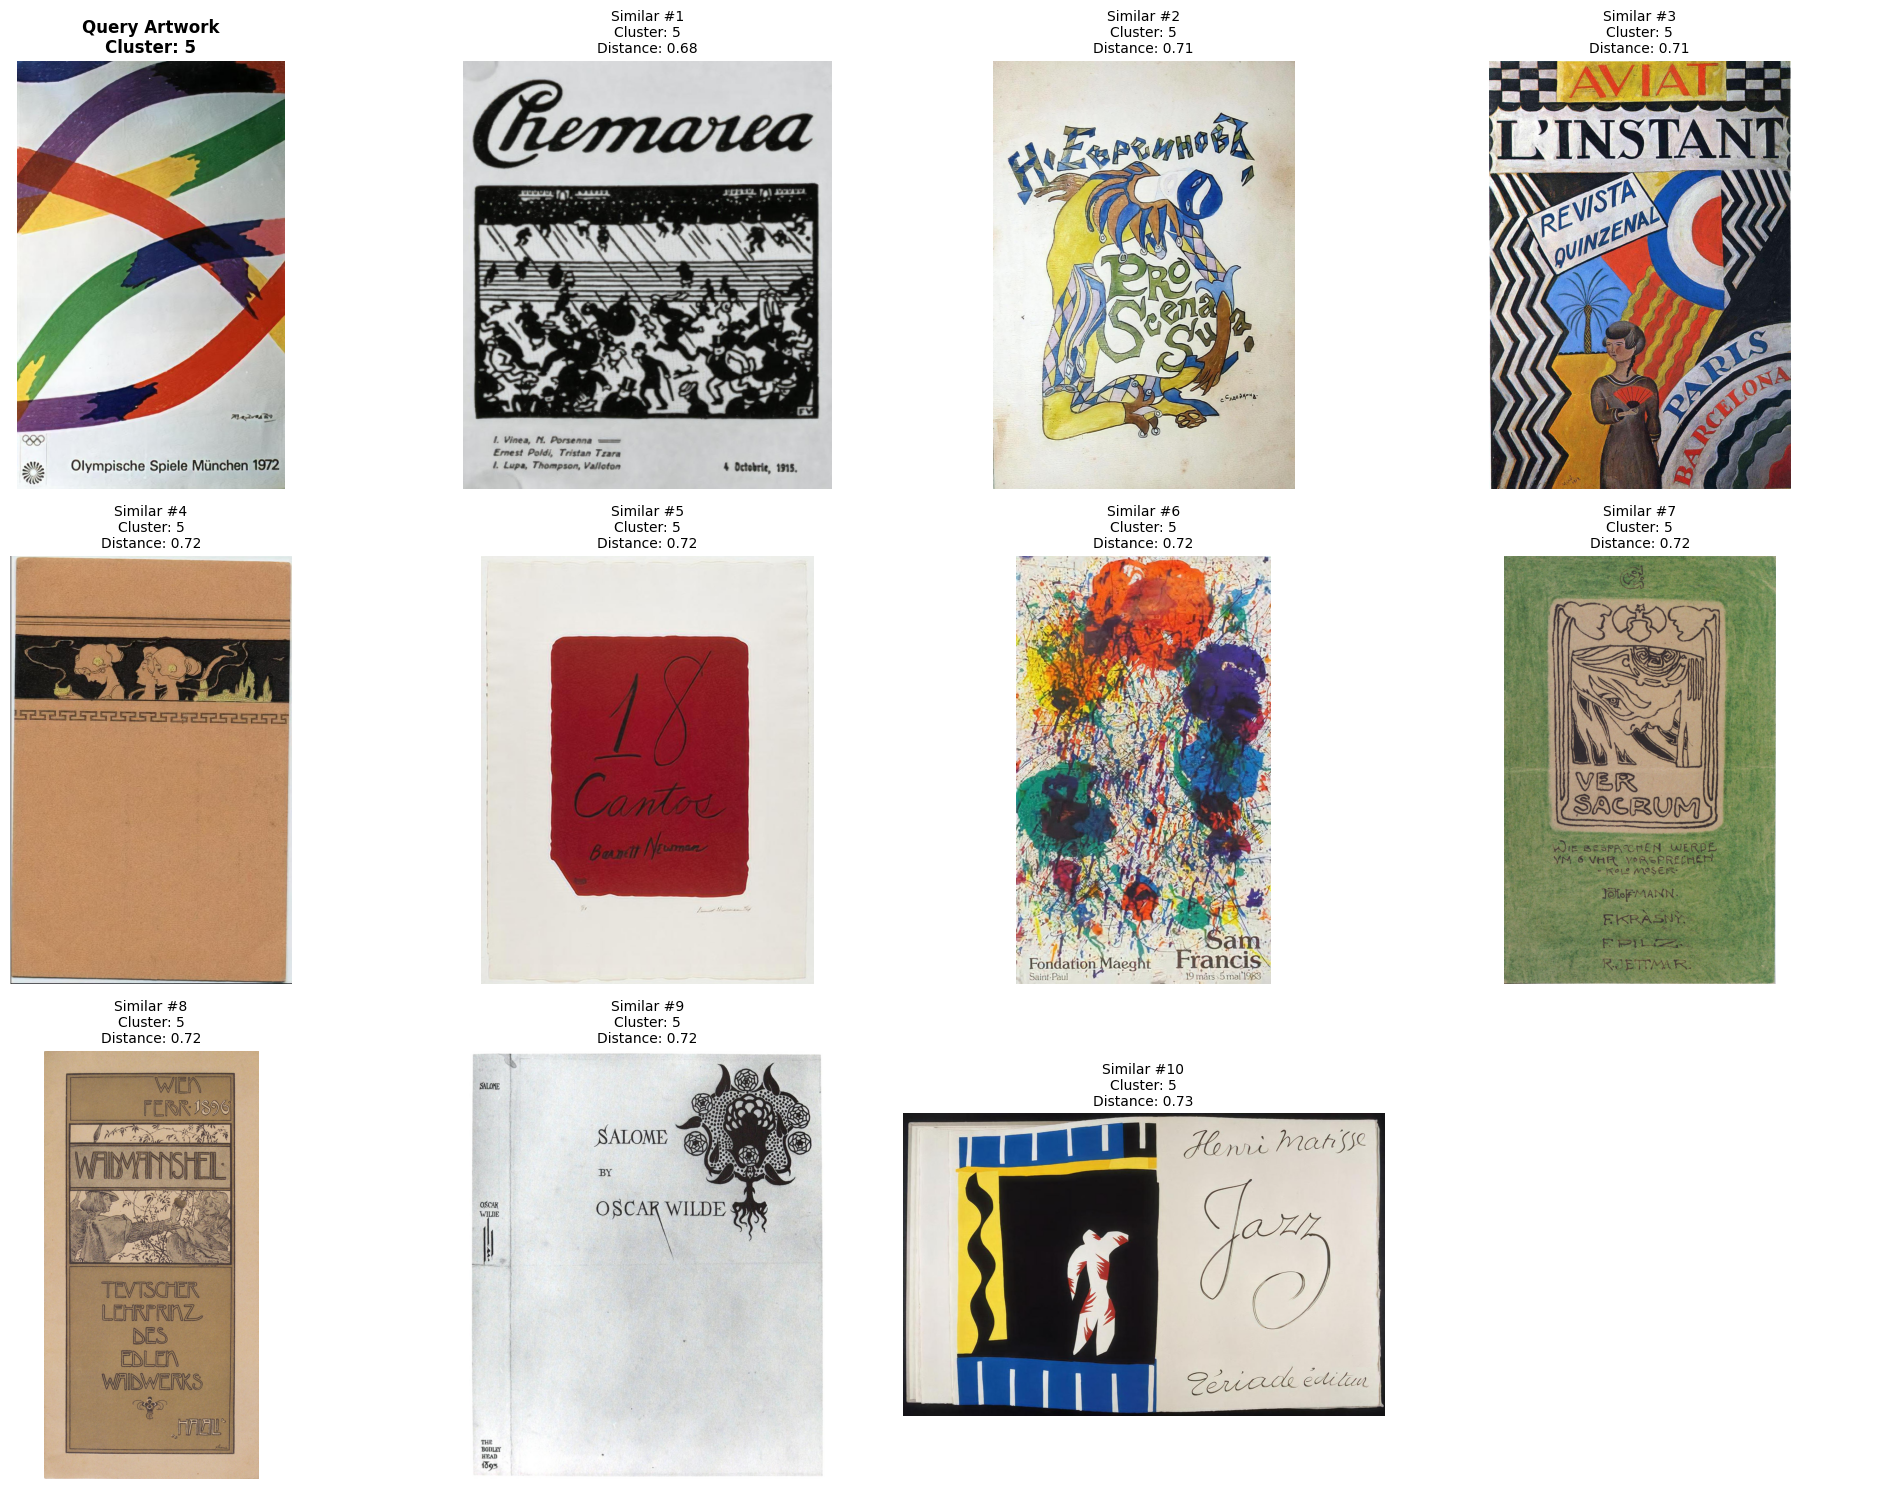

filename            artist  \
2934   Art_Nouveau_Modern/felix-vallotton_cover-of-th...   felix vallotton   
5037   Art_Nouveau_Modern/serge-sudeikin_draft-for-a-...    serge sudeikin   
14871           Cubism/joan-miro_not_detected_227962.jpg         joan miro   
13348  Art_Nouveau_Modern/raphael-kirchner_scenes-of-...  raphael kirchner   
8895   Color_Field_Painting/barnett-newman_title-page...    barnett newman   
9851   Color_Field_Painting/sam-francis_exposition-sa...       sam francis   
13078  Art_Nouveau_Modern/koloman-moser_postcard-to-c...     koloman moser   
3903   Art_Nouveau_Modern/koloman-moser_waidmannsheil...     koloman moser   
2359   Art_Nouveau_Modern/aubrey-beardsley_cover-and-...  aubrey beardsley   
733    Abstract_Expressionism/henri-matisse_jazz-book...     henri matisse   

                                                   genre  \
2934                              ['Art Nouveau Modern']   
5037                              ['Art Nouveau Modern']   
14871                                         ['Cubism']   
13348                             ['Art Nouveau Modern']   
8895                            ['Color Field Painting']   
9851   ['Color Field Painting', 'Abstract Expressioni...   
13078                             ['Art Nouveau Modern']   
3903                              ['Art Nouveau Modern']   
2359                              ['Art Nouveau Modern']   
733                           ['Abstract Expressionism']   

                                             description             phash  \
2934   cover-of-the-romanian-symbolist-and-avant-gard...  ba878518c51f78e5   
5037   draft-for-a-book-cover-nikolai-evreinov-pro-sc...  ed9396cad0351933   
14871                                not_detected_227962  d2dc232f53870b1e   
13348                    scenes-of-ancient-greece-1903-1  cb5fa2b4b4b4150b   
8895                      title-page-from-18-cantos-1964  e93c97c196c3388e   
9851    exposition-sam-francis-19-mars-5-mai-1983-poster  fa78b526c0e5ce09   
13078              postcard-to-carl-moll-ver-sacrum-1897  8a87677b187c2971   
3903                                  waidmannsheil-1896  af4cd171c44e9539   
2359                           cover-and-spine-1893-1893  ca4aca9594b593b9   
733                                       jazz-book-1947  bfe141c646be5033   

       width  height  genre_count subset  \
2934    1382    1605            1  train   
5037    1382    1966            1  train   
14871   1382    1962            1   test   
13348   1382    2099            1   test   
8895    1382    1780            1  train   
9851    1382    2325            2  train   
13078   1382    2180            1   test   
3903    1382    2760            1  train   
2359    1382    1659            1  train   
733     2196    1382            1  train   

                                                  vector  cluster  distance  
2934   [0.018129713833332062, 0.04682261124253273, 0....        5  0.679830  
5037   [0.0031382711604237556, -0.009769413620233536,...        5  0.705375  
14871  [0.0052710906602442265, -0.033254917711019516,...        5  0.711626  
13348  [-0.005248744506388903, -0.01732117123901844, ...        5  0.715641  
8895   [0.023397961631417274, -0.03146743029356003, 0...        5  0.720010  
9851   [0.0019025085493922234, -0.08117110282182693, ...        5  0.720036  
13078  [-0.01972108520567417, -0.006424667779356241, ...        5  0.721044  
3903   [-0.01549731008708477, -0.007412589620798826, ...        5  0.722733  
2359   [0.00817441288381815, -0.021877402439713478, 0...        5  0.724209  
733    [0.020338015630841255, -0.046066075563430786, ...        5  0.726261

In [63]:
get_similar_artworks_gmm("ca6f155f72608716")

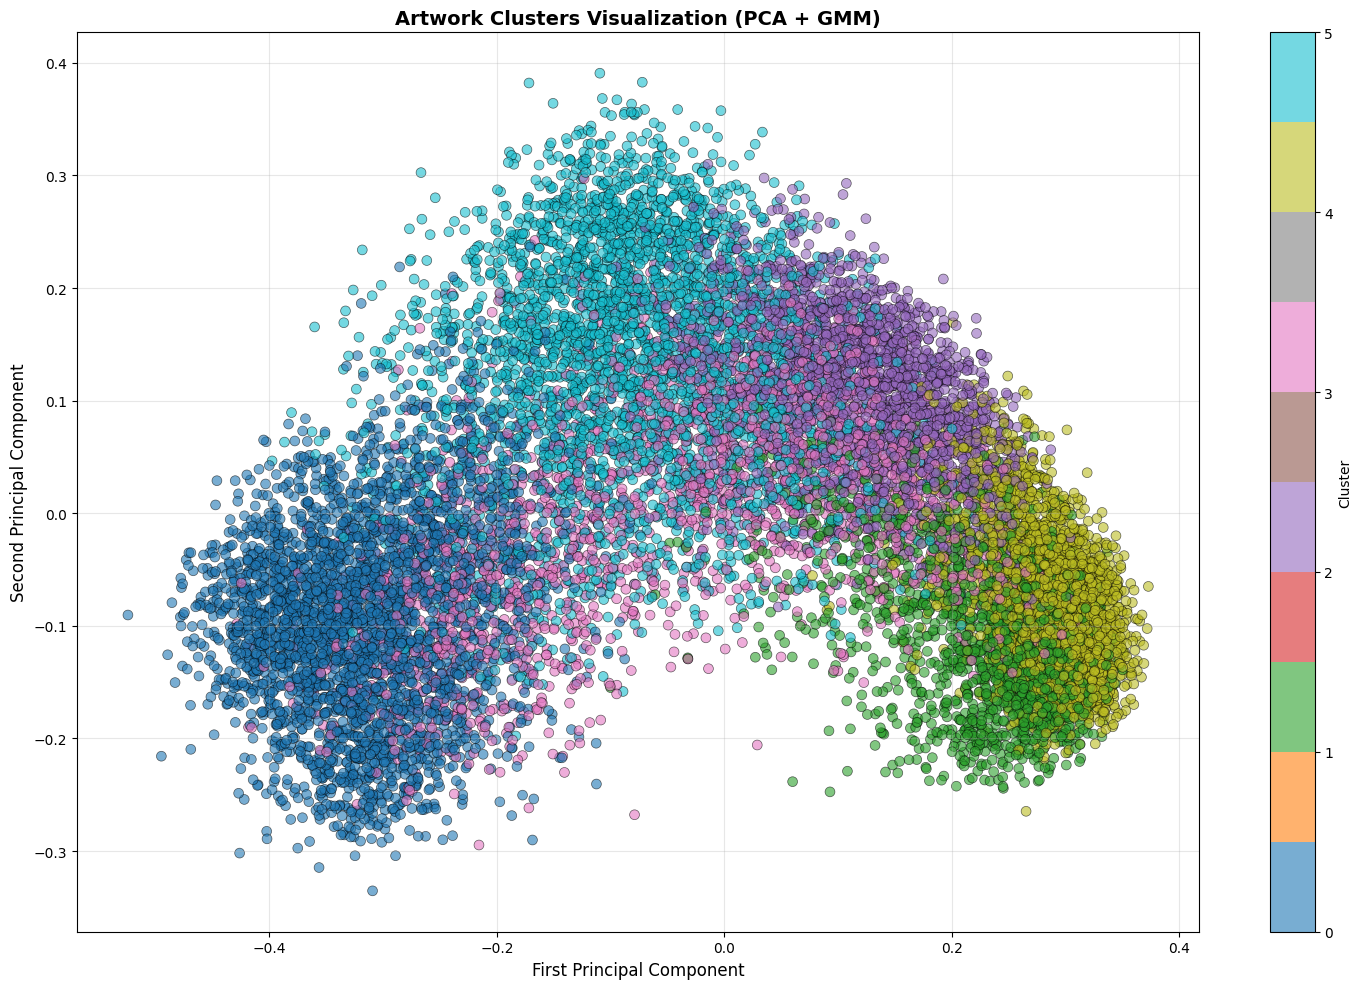

In [64]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], 
                     c=cluster_labels, 
                     cmap='tab10', 
                     alpha=0.6, 
                     s=50,
                     edgecolors='black',
                     linewidth=0.5)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('Artwork Clusters Visualization (PCA + GMM)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### b/ similarity search using FAISS

In [65]:
clean_dataset['vector'] = clean_dataset['vector'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
vectors_array = np.array(clean_dataset['vector'].tolist()).astype('float32')

# Build FAISS index
dimension = vectors_array.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(vectors_array)

print(f"FAISS index built with {index.ntotal} vectors of dimension {dimension}")

FAISS index built with 15134 vectors of dimension 512


In [66]:
def get_similar_artworks(phash, k=10):
    """
    Find k most similar artworks to the given phash using FAISS and plot them.
    
    Parameters:
    - phash: The phash of the artwork to find similar pieces for
    - k: Number of similar artworks to return (default: 10)
    
    Returns:
    - DataFrame with the k most similar artworks
    """
    # Find the artwork with the given phash
    artwork_row = clean_dataset[clean_dataset['phash'] == phash]
    
    if artwork_row.empty:
        print(f"No artwork found with phash: {phash}")
        return None
    
    # Get the vector of the input artwork
    query_vector = np.array(artwork_row['vector'].iloc[0]).astype('float32').reshape(1, -1)
    
    # Search for k+1 nearest neighbors (including the query itself)
    distances, indices = index.search(query_vector, k + 1)
    
    # Remove the first result (the query itself)
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]
    
    # Get the similar artworks from the dataset
    similar_artworks = clean_dataset.iloc[similar_indices].copy()
    similar_artworks['distance'] = similar_distances
    
    # Plot the query artwork and similar artworks
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    # Plot the query artwork in the first position
    query_img_path = artwork_row['filename'].iloc[0]
    if os.path.exists(query_img_path):
        query_img = cv2.imread(query_img_path)
        query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
        axes[0].imshow(query_img)
        axes[0].set_title(f'Query Artwork', fontsize=12, fontweight='bold')
        axes[0].axis('off')
    
    # Plot the similar artworks
    for i, (idx, row) in enumerate(similar_artworks.iterrows(), start=1):
        img_path = row['filename']
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(f'Similar #{i} {row["description"]} [\nDistance: {row["distance"]:.2f}', fontsize=10)
            axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(len(similar_artworks) + 1, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return similar_artworks

In [67]:
get_similar_artworks("ca6f155f72608716")

filename               artist  \
10682               Cubism/fernand-leger_man-in-town.jpg        fernand leger   
14344  Color_Field_Painting/bridget-riley_rose-rose-l...        bridget riley   
1318   Abstract_Expressionism/paul-jenkins_distance-f...         paul jenkins   
8846   Color_Field_Painting/antonio-palolo_lisbon-197...       antonio palolo   
14575  Color_Field_Painting/sam-francis_untitled-1965...          sam francis   
1787   Abstract_Expressionism/sam-francis_untitled-fr...          sam francis   
1615   Abstract_Expressionism/ronnie-landfield_the-st...     ronnie landfield   
12506  Abstract_Expressionism/ronnie-landfield_untitl...     ronnie landfield   
9269   Color_Field_Painting/helen-frankenthaler_untit...  helen frankenthaler   
9838   Color_Field_Painting/ronnie-landfield_village-...     ronnie landfield   

                                                   genre  \
10682                                         ['Cubism']   
14344                           ['Color Field Painting']   
1318                          ['Abstract Expressionism']   
8846                            ['Color Field Painting']   
14575  ['Color Field Painting', 'Abstract Expressioni...   
1787                          ['Abstract Expressionism']   
1615                          ['Abstract Expressionism']   
12506                         ['Abstract Expressionism']   
9269                            ['Color Field Painting']   
9838                            ['Color Field Painting']   

                                           description             phash  \
10682                                      man-in-town  f93186ce998e4e89   
14344  rose-rose-london-2012-olympic-games-poster-2012  ff2ad528d52ac5a0   
1318                           distance-finding-mozart  afbd80d29f61b442   
8846                                       lisbon-1973  e3e31cc15c1cc73c   
14575                                  untitled-1965-2  d5f2227827316d2b   
1787       untitled-from-pasadena-box-lembark-l62-1963  ee669d8d904af093   
1615           the-storm-from-denver-to-the-bronx-1970  dfdc1447e4d88983   
12506                                    untitles-1964  a0cfdf7620cecd20   
9269                                     untitled-1967  9535e2467c407fe1   
9838                          village-in-the-moon-1985  abb5d44a85363ac9   

       width  height  genre_count subset  \
10682   1382    1837            1  train   
14344   1382    1837            1   test   
1318    1382    1886            1  train   
8846    1382    1736            1  train   
14575   1382    1815            2   test   
1787    1382    1794            1  train   
1615    1620    1382            1  train   
12506   1382    1700            1   test   
9269    1382    1997            1  train   
9838    1502    1382            1  train   

                                                  vector  cluster  distance  
10682  [0.027382798492908478, -0.013057303614914417, ...        2  0.623340  
14344  [-0.023659231141209602, 0.016236256808042526, ...        1  0.643061  
1318   [0.05416485667228699, 0.00790355447679758, 0.0...        4  0.661530  
8846   [0.023810403421521187, -0.029881956055760384, ...        1  0.669152  
14575  [0.033964354544878006, -0.007016567979007959, ...        4  0.669267  
1787   [0.03758743405342102, -0.02027176506817341, 0....        4  0.688012  
1615   [0.027828766033053398, -0.016324596479535103, ...        4  0.689739  
12506  [0.009520250372588634, -0.021899551153182983, ...        4  0.691613  
9269   [0.03935417905449867, -0.021611511707305908, 0...        4  0.700907  
9838   [0.034783199429512024, -0.05549122393131256, 0...        4  0.708404

## Conclusion

In term of results relevance, it is clear that FAISS performs better than PCA + GMM. In term of computational efficiency, both are similar computing the similarity search in <1s (0.8s for PCA+GMM and 0.9s for FAISS). Therefore we are going to use FAISS for the implementation of the application.